# Simulate a compound double pendulum system

References: 
- https://www.youtube.com/watch?v=QE1_H2vtHLU (EoM for the Double Compound Pendulum, "Good Vibrations with Freeball").
- https://underactuated.mit.edu/acrobot.html#section1


![](figures/double-pendulum-compound.png)

In [1]:
using Pkg
Pkg.activate(".")
Pkg.instantiate()
IJulia.clear_output();

In [2]:
using Printf
using Plots
default(label="", grid=false, margin=10Plots.pt)

In [3]:
function polar2cart_com(z; l1=1, l2=1)
    "Map angles of centers of masses to Cartesian space"

    # Position of first mass
    x1 = l1/2*sin(z[1])
    y1 = l1/2*-cos(z[1])
    
    # Position of second mass
    x2 =  l1*sin(z[1]) + l2/2*sin(z[2])
    y2 = -l1*cos(z[1]) - l2/2*cos(z[2])
    
    return (x1,y1), (x2,y2)
end

polar2cart_com (generic function with 1 method)

In [4]:
function polar2cart_rod(z; l1=1, l2=1)
    "Map end points of rods to Cartesian space"

    # End position of first rod
    x1 = l1*sin(z[1])
    y1 = l1*-cos(z[1])
    
    # End position of second mass
    x2 = x1 + l2*sin(z[2])
    y2 = y1 - l2*cos(z[2])
    
    return (x1,y1), (x2,y2)
end

polar2cart_rod (generic function with 1 method)

## Manual simulation

Using Lagrangian mechanics, we obtain the following equations of motion:

$$\begin{align} 
J_a \ddot{\theta}_1 + J_x \cos(\theta_1 - \theta_2)\ddot{\theta}_2 + J_x \sin(\theta_1 - \theta_2)\dot{\theta}_2^2 + \mu_1 \sin \theta_1 - K_t (\theta_2 - \theta_1) &= 0 \\
J_b \ddot{\theta}_2 + J_x \cos(\theta_1 - \theta_2)\ddot{\theta}_1 - J_x \sin(\theta_1 - \theta_2)\dot{\theta}_1^2 + \mu_2 \sin \theta_2 - K_t (\theta_2 - \theta_1) &= 0
\end{align}$$

where we've used the shorthand notation:

$$\begin{align}
J_a = \frac{1}{3}m_1 l_1^2 + m_2 l_1^2 \, , \quad
J_b = \frac{1}{3}m_2 l_2^2 \, , \quad
J_x = \frac{1}{2}m_2 l_1 l_2 \, , \quad
\mu_1 = (\frac{1}{2}m_1 + m_2)Gl_2 \, , \quad
\mu_2 = \frac{1}{2}m_2 G l_2 \, .
\end{align}$$

We'd like to isolate the second-order derivates on one side:

$$\begin{align} 
J_a \ddot{\theta}_1 + J_x \cos(\theta_1 - \theta_2)\ddot{\theta}_2 &= - J_x \sin(\theta_1 - \theta_2)\dot{\theta}_2^2 - \mu_1 \sin \theta_1 + K_t (\theta_2 - \theta_1) \\
J_x \cos(\theta_1 - \theta_2)\ddot{\theta}_1 + J_b \ddot{\theta}_2 &= J_x \sin(\theta_1 - \theta_2)\dot{\theta}_1^2 - \mu_2 \sin \theta_2 + K_t (\theta_2 - \theta_1)
\end{align}$$

We can formulate the left-hand side as a matrix-vector product:

$$\begin{align} 
\underbrace{\begin{bmatrix} J_a & J_x \cos(\theta_1 - \theta_2) \\ J_x \cos(\theta_1 - \theta_2) & J_b \end{bmatrix}}_{M(\theta_1, \theta_2)} \begin{bmatrix} \ddot{\theta}_1 \\ \ddot{\theta}_2 \end{bmatrix} = \begin{bmatrix} - J_x \sin(\theta_1 - \theta_2)\dot{\theta}_2^2 - \mu_1 \sin \theta_1 + K_t (\theta_2 - \theta_1) \\
 J_x \sin(\theta_1 - \theta_2)\dot{\theta}_1^2 - \mu_2 \sin \theta_2 + K_t (\theta_2 - \theta_1) \end{bmatrix}
\end{align}$$

and then move the mass matrix to the right-hand side:

$$\begin{align} 
\begin{bmatrix} \ddot{\theta}_1 \\ \ddot{\theta}_2 \end{bmatrix} = M(\theta_1, \theta_2)^{-1} \begin{bmatrix} - J_x \sin(\theta_1 - \theta_2)\dot{\theta}_2^2 - \mu_1 \sin \theta_1 + K_t (\theta_2 - \theta_1) \\
 J_x \sin(\theta_1 - \theta_2)\dot{\theta}_1^2 - \mu_2 \sin \theta_2 + K_t (\theta_2 - \theta_1) \end{bmatrix}
\end{align}$$

The inverse mass matrix can be derived manually:

$$\begin{align}
M^{-1} = 
\end{align}$$


Now, we can use variable substitution, 

$$\begin{align}
z = \begin{bmatrix} \theta_1 & \theta_2 & \dot{\theta}_1 & \dot{\theta}_2 \end{bmatrix}^{\top}
\end{align} \, ,$$

to transform this into a first-order system:

$$\begin{align} 
\dot{z} = \begin{bmatrix} z_3 \\ z_4 \\ M(z_1,z_2)^{-1} \begin{bmatrix} - J_x \sin(\theta_1 - \theta_2)\dot{\theta}_2^2 - \mu_1 \sin \theta_1 + K_t (\theta_2 - \theta_1) \\
 J_x \sin(\theta_1 - \theta_2)\dot{\theta}_1^2 - \mu_2 \sin \theta_2 + K_t (\theta_2 - \theta_1) \end{bmatrix} \end{bmatrix}
\end{align}$$

### Discretization

I'll be using a 4-order Runge-Kutta method to obtain a numerical solution.

In [5]:
# Define time scales
tspan = (0.,30.)
dt = 0.05
time = tspan[1]:dt:tspan[end]
T = length(time)

601

In [6]:
# System parameters
m1 = 1   # kg
m2 = 1   # kg
l1 = 1   # m
l2 = 1   # m
kt = 0   # Torsional spring
const G = 9.81 # N or kg*m / s^2

9.81

In [7]:
# Control
ut = 0

0

In [8]:
# Shorthand notation
Ja = 1/3*m1*l1^2 + m2*l1^2
Jb = 1/3*m2*l2^2
Jx = 1/2*m2*l1*l2
μ1 = (1/2*m1 + m2)*G*l1
μ2 = 1/2*m2*G*l2

4.905

In [9]:
function dzdt(z,t)
   "Derivative function"
    
    # Shorthand for matrix inversion
    A = Ja
    B = Jx*cos(z[1] - z[2])
    C = B
    D = Jb
    
    # Inverse mass (inertia matrix)
    Mi = 1/(A*D - B*C)*[D -B;-C A]
    
    # Equations of motion
    ddθ1 = -Jx*sin(z[1] - z[2])*z[4]^2 - μ1*sin(z[1]) + kt*sin(z[2] - z[1])
    ddθ2 =  Jx*sin(z[1] - z[2])*z[3]^2 - μ2*sin(z[2]) + kt*sin(z[2] - z[1])
    ddθ = Mi*[ddθ1, ddθ2]
    
    # Equations of motion
    return [z[3]; z[4]; ddθ[1]; ddθ[2]]
end

dzdt (generic function with 1 method)

In [10]:
function RK4(z,t,dt)

    K1 = dzdt(z,t)
    K2 = dzdt(z + K1*dt/2, t+dt/2)
    K3 = dzdt(z + K2*dt/2, t+dt/2)
    K4 = dzdt(z + K3*dt, t+dt)

    return dt*1/6*(K1 + 2*K2 + 2*K3 + K4)
end

RK4 (generic function with 1 method)

In [11]:
# Allocate
z_ = zeros(4,T)

# Initial state
z_0 = [π/2, π/2, 0, 0]

# Define previous timepoint
z_tmin1 = z_0

# Time-stepping
for (ii,t) in enumerate(time)

    # Update state
    z_[:,ii] = z_tmin1 + RK4(z_tmin1,t, dt)

    # Update previous variables
    z_tmin1 = z_[:,ii]

end

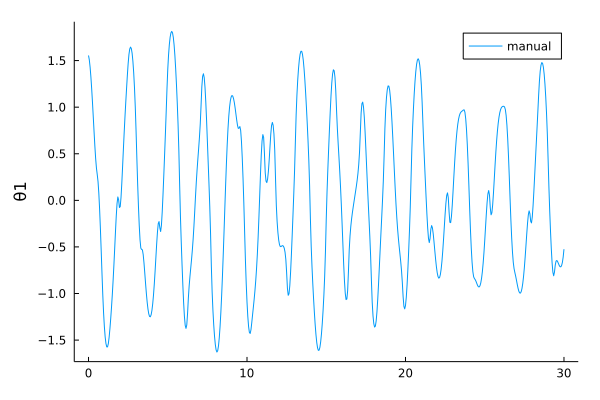

In [12]:
plot(time, z_[1,:], label="manual", ylabel="θ1")

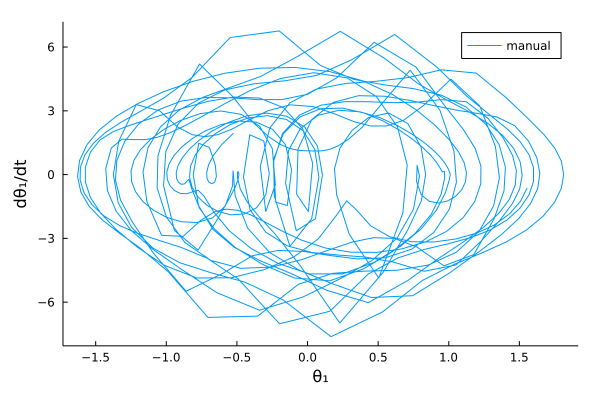

In [13]:
plot(z_[1,:], z_[3,:], label="manual", xlabel="θ₁", ylabel="dθ₁/dt")

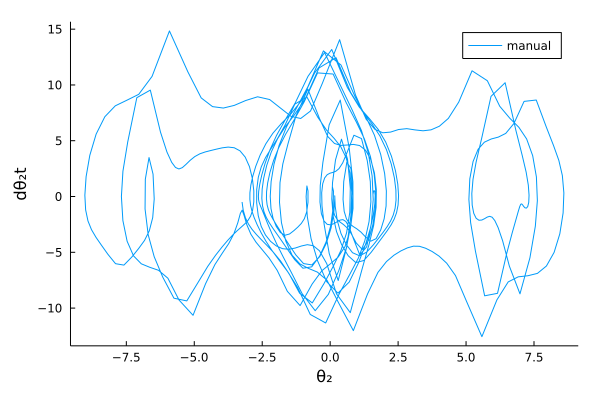

In [14]:
plot(z_[2,:], z_[4,:], label="manual", xlabel="θ₂", ylabel="dθ₂t")

┌ Info: Saved animation to 
│   fn = /home/wmkouw/syndr/Wouter/Onderzoek/Demonstraties/tue/actinf-acrobot/figures/dpend-compound.gif
└ @ Plots /home/wmkouw/.julia/packages/Plots/E2187/src/animation.jl:126


Plots.AnimatedGif("/home/wmkouw/syndr/Wouter/Onderzoek/Demonstraties/tue/actinf-acrobot/figures/dpend-compound.gif")
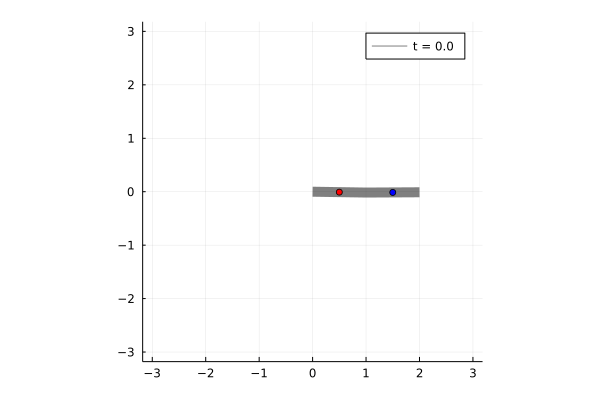

In [15]:
anim = @animate for (i,t) in enumerate(time)
   
    # Cartesian positions of centers of mass
    com1, com2 = polar2cart_com(z_[:,i], l1=l1, l2=l2)
    
    # Cartesian positions of rod endpoints
    rod1, rod2 = polar2cart_rod(z_[:,i], l1=l1, l2=l2)
    
    # Concatenate
    pen_k = [0 0; rod1[1] rod1[2]; rod2[1] rod2[2]]
    
    # Plot line
    plot(pen_k[:,1], pen_k[:,2], linewidth=10, alpha=0.5, label=@sprintf("t = %.1f", t), xlims=[-3,3], ylims=[-3,3], aspect_ratio=:equal, grid=true, color="black")
    
    # Point masses
    scatter!([com1[1]], [com1[2]], color="red")
    scatter!([com2[1]], [com2[2]], color="blue")
    
end
gif(anim, "figures/dpend-compound.gif", fps=100)